# Generate the Fusion Results Using Hybrid Search
Due to the advancements in deep learning this year, we have seen the emergence of exceptional models with diverse capabilities. One significant area of innovation is in search embeddings models, which perform similarity searches in various ways. By employing hybrid search techniques, it is possible to combine the results from these models, effectively eliminating duplicate elements while returning more diverse results that integrate different strengths. We will demonstrate this using the example of searching for image. Specifically, we will show how to use the WeightedRank in Milvus to achieve this, highlighting how different embedding strategies can be blended to enhance search outcomes in practical scenarios.

**Dataset**     
Dataset in pics folder

**ResNet**       
ResNet, short for Residual Network, is a foundational model in the field of deep learning that has significantly advanced research in image recognition and classification. We use ResNet-34 as our feature extractor, as it has been trained on ImageNet, enabling it to effectively distinguish between images in the dataset.   

**CLIP**   
CLIP, short for Contrastive Language–Image Pre-training, is a revolutionary model that bridges the gap between visual and textual data, significantly advancing the field of multimodal learning. Developed by OpenAI, CLIP is trained on a diverse range of internet-collected data, enabling it to understand and classify images in the context of natural language descriptions. We use its features extracted from captions to search for images.

## Prerequisite
Checkout [Milvus official website](https://milvus.io/docs/install_standalone-docker.md) to install milvus>=2.4.0. And install PyMilvus and other dependencies by 
```bash
!pip3 install -r requirements.txt
```

## Prepare Dataset
Downloaded several pictures about signal lights, placed them in the **pics** folder.  
Run this script to insert embeddings into Milvus

In [2]:
!python3 gen_features.py

/Users/zilliz/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
Python-dotenv could not parse statement starting at line 1
Python-dotenv could not parse statement starting at line 2
Python-dotenv could not parse statement starting at line 3
Python-dotenv could not parse statement starting at line 14
Python-dotenv could not parse statement starting at line 17


## Target picture
<img src="./pics/8215257ecb57bdba0c7de7a731ad3bf5.jpg" alt="Sample Image" title="Sample Image" width="30%"/>
    <!-- <img src="./red2.jpg" alt="Sample Image" title="Sample Image" width="5%"/> -->


## Search Using ResNet Feature
After inserting features from the dataset into Milvus, let's assume that we only got a piece of the picture to start with, search it in Milvus!
<div style="text-align: center;">
<img src="./sample.jpg" alt="Sample Image" title="Sample Image" width="3%"/>
</div>

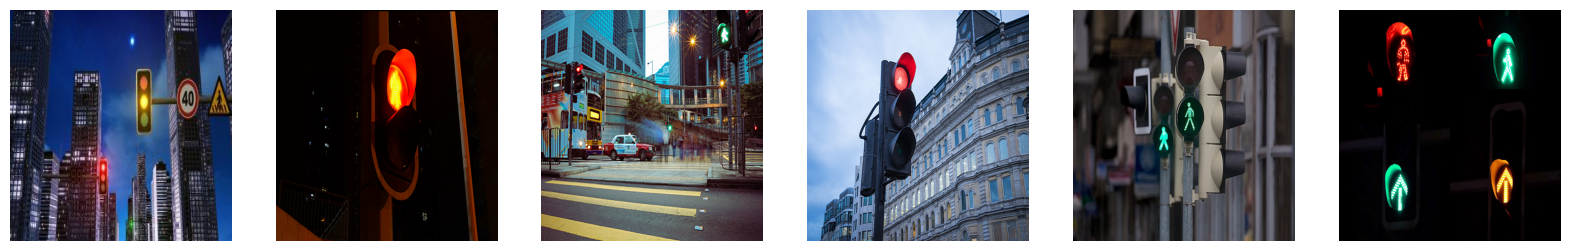

In [3]:
from search import show_images_horizontally
from pymilvus import Collection, connections
from gen_features import ResNetFeatureExtractor 
import os
import numpy as np
from PIL import Image

os.makedirs('resnet', exist_ok=True) 
connections.connect("default", host="10.102.6.136", port="19530")
col_name = f'multimodal'
col = Collection(col_name)
col.load()

resnet_fe = ResNetFeatureExtractor()

image = Image.open("sample.jpg").convert('RGB')
featr = resnet_fe(image).detach().cpu().numpy()
featr = featr / np.linalg.norm(featr)

resnet_search_params = {"metric_type": "IP", "params": {}}
results = col.search(featr, anns_field="resnet_vector", param=resnet_search_params, limit=6, output_fields=['filename'])
for i, result in enumerate(results[0]):
    os.system(f'cp ./pics/{result.filename}  resnet/res{i}.jpg ')

show_images_horizontally('./resnet', 20, 3)

These returns focus on the traffic signal style, they are all vertical traffic lights, among these result, the 3nd pic is the truth one.

## Search Using CLIP Feature

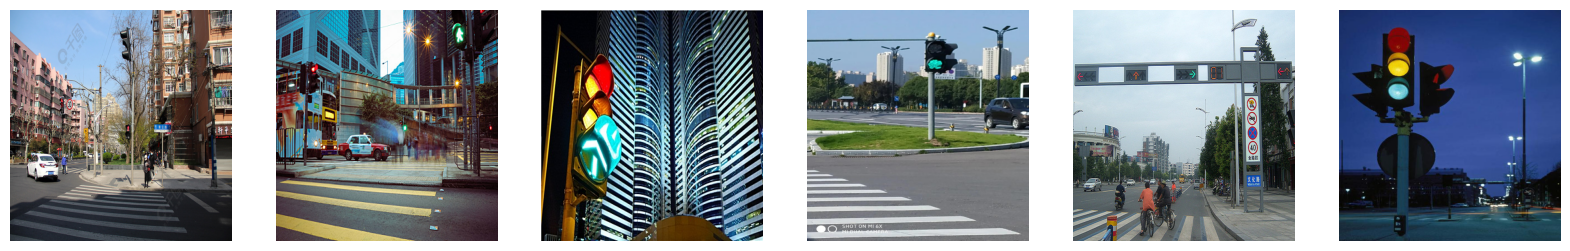

In [4]:
from search import show_images_horizontally
from gen_features import CLIPFeatureExtractor 
import os
import numpy as np

os.makedirs('clip', exist_ok=True) 

clip_fe = CLIPFeatureExtractor()

text = "with buildings at background"
# text = "crosswalk"
featc = clip_fe(text).detach().cpu().numpy()
featc = featc / np.linalg.norm(featc)

clip_search_params = {"metric_type": "IP", "params": {}}
results = col.search(featc, anns_field="clip_vector", param=clip_search_params, limit=6, output_fields=['filename'])
for i, result in enumerate(results[0]):
    os.system(f'cp ./pics/{result.filename}  clip/res{i}.jpg ')

show_images_horizontally('./clip', 20, 3)

pictures with buildings/crosswalk returned as our description, you can see the 2nd image is the exactly one.

## Search the Hybrid Results using reranker
we use weightedranker to fusion the result, we will mix the recall results of each path with a weighted average sum for the final ranking

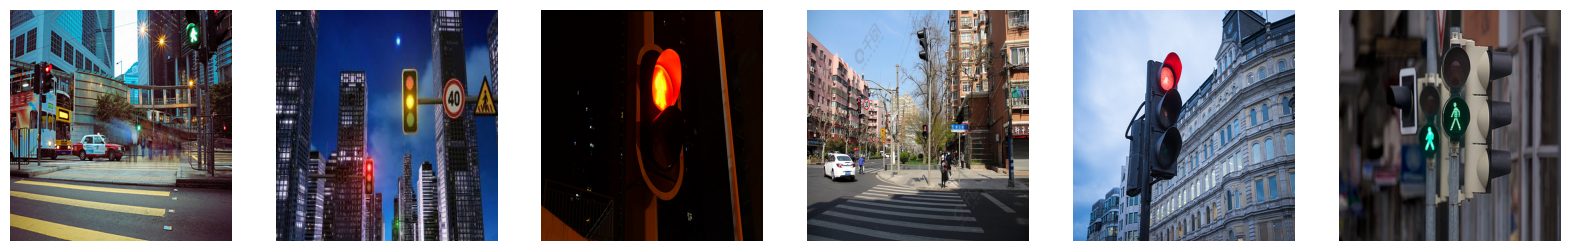

In [5]:
from search import show_images_horizontally
from pymilvus import AnnSearchRequest, WeightedRanker
os.makedirs('hybrid', exist_ok=True) 

resnet_req = AnnSearchRequest(featr, "resnet_vector", resnet_search_params, limit=10)
clip_req = AnnSearchRequest(featc, "clip_vector", clip_search_params, limit=10)
results = col.hybrid_search([resnet_req, clip_req], rerank=WeightedRanker(0.7,0.8), limit=6, output_fields=['filename'])
for i, result in enumerate(results[0]):
    os.system(f'cp ./pics/{result.filename}  hybrid/res{i}.jpg ')

show_images_horizontally('./hybrid', 20, 3)

Now the truth result is ordered at first place. we get a more accurate result by using hybrid search, using pic as detailed info and using text as background description.